In [189]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime, timedelta
import re
import matplotlib.dates as mdates
import joypy
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [190]:
buoy_lookup = {
 "Diablo Canyon":"076",
 "Point Sur":"157",
 "Cabrillo Point":"158",
 "Monterey Bay":"185",
 "SF Bar":"142",
 "Point Reyes":"029",
 "Cape Mendocino":"094",
 "Humboldt Bay":"168"
}

In [6]:
def get_buoy_data(buoy_id):
    ''' Generate a url request string based on the CDIP thredds '''
    base_str = "https://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/"
    request_url = base_str + buoy_id+ 'p1_rt.nc'
    try:
        return xr.open_dataset(request_url)
    except:
        return None

def plot_buoy(ds,param='waveHs',ax=None, max_hs=False):
    ''' Plot the last month of Significant wave height given a dataset '''
    if ax is None:
        ax = plt.axes()
    last_month = ds.sel(waveTime=slice(datetime.now()-timedelta(days=10),datetime.now()))
    sig_wave = last_month['waveHs'].values
    time_utc = last_month['waveTime'].to_pandas().tz_localize('UTC')
    time_pst = time_utc.tz_convert('US/Pacific')
    ax.plot(time_pst,sig_wave/0.3048,lw=3)
    if max_hs:
        max_hs = sig_wave.max()/0.3048

    last_month = ds.sel(waveTime=slice(datetime.now()-timedelta(days=1),datetime.now()))
    sig_wave = last_month['waveHs'].values
    time_utc = last_month['waveTime'].to_pandas().tz_localize('UTC')
    time_pst = time_utc.tz_convert('US/Pacific')
    ax.plot(time_pst,sig_wave/0.3048,lw=3)
    if max_hs:
        return ax, last_month, max_hs

    else:
        return ax, last_month

def plot_buoy_period(ds,param='waveTp',ax=None):
    ''' Plot the last month of Significant wave height given a dataset '''
    if ax is None:
        ax = plt.axes()
    last_month = ds.sel(waveTime=slice(datetime.now()-timedelta(days=7),datetime.now()))
    sig_wave = last_month[param].values
    time_utc = last_month['waveTime'].to_pandas().tz_localize('UTC')
    time_pst = time_utc.tz_convert('US/Pacific')
    ax.plot(time_pst,sig_wave,lw=3)
    last_month = ds.sel(waveTime=slice(datetime.now()-timedelta(days=1),datetime.now()))
    sig_wave = last_month[param].values
    time_utc = last_month['waveTime'].to_pandas().tz_localize('UTC')
    time_pst = time_utc.tz_convert('US/Pacific')
    ax.plot(time_pst,sig_wave,lw=3)
    return ax, last_month

def format_axis(ax,right=False):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    ax.tick_params(axis='both', labelsize=16, colors="#2F5596")
    if right:
        ax.spines['right'].set_visible(False)
        ax.yaxis.set_tick_params(width=3,length=7,colors="#2F5596")
        ax.set_yticks([5,10,15])
    else:
        ax.spines['right'].set_visible(False)
        ax.set_yticks([])
    return ax

In [7]:
buoy_lookup = {
    "Humboldt Bay":"168",
    "Cape Mendocino":"094",
     "Point Reyes":"029",
     "SF Bar":"142",
     "Monterey Bay":"185",
     "Cabrillo Point":"158",
     "Point Sur":"157",
     "Diablo Canyon":"076",
}

# buoy_lookup = {
#     "Humboldt Bay":"168",
#     "Cape Mendocino":"094",
#      "Point Reyes":"029",
#      "SF Bar":"142",
#      "Monterey Bay":"185",
#      "Point Sur":"157",
#      "Diablo Canyon":"076",
# }


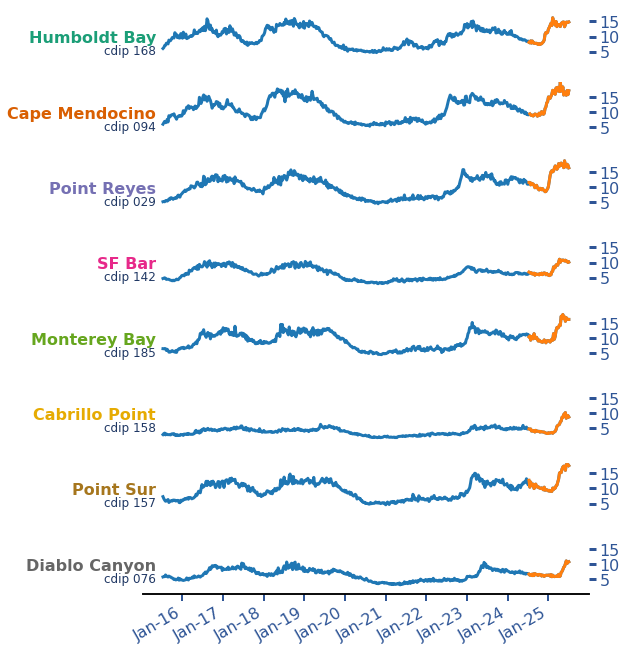

In [178]:
fig, ax = plt.subplots(len(buoy_lookup),sharex=True,gridspec_kw={"hspace":0.25})
# gs1 = gridspec.GridSpec(4, 4)
# gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 
fig.set_size_inches(w=8,h=len(buoy_lookup)*1.5)

fig.autofmt_xdate()
lats = []
lons = []
station_name = []
for i, (key, value) in enumerate(buoy_lookup.items()):
    ds = get_buoy_data(value)
    station_name.append(key)
    if ds is None:
        lats.append(None)
        lons.append(None)
        ax_current = ax[i].twinx()
        ax_current.text(x=.03, y=.4, s=key,
                        size=16,
                        color='#2F5596', 
                        weight='bold',
                        transform=ax_current.transAxes, 
                        horizontalalignment='right')
        ax_current.text(x=.03, y=.2, s='cdip '+value, size=12,color='#203864', transform=ax_current.transAxes, horizontalalignment='right')
        ax_current.text(x=.5, y=.2, s="Station Offline", size=25, alpha=.5, color="#203864", transform=ax_current.transAxes, horizontalalignment='center')
        ax_current = format_axis(ax_current,right=True)
        ax[i] = format_axis(ax[i])
        ax_current.set_yticks([])



    else:
        lat = ds.isel(gpsTime=-1)['gpsLatitude'].values
        lon = ds.isel(gpsTime=-1)['gpsLongitude'].values
        lats.append(lat)
        lons.append(lon)

        ax_current = ax[i].twinx()
        ax_current, ds, max_hs = plot_buoy(ds, ax=ax_current,max_hs=True)
        ax_current.set_ylim(0,20)
        cmap = matplotlib.cm.get_cmap('Dark2')
#         ax_current.text(x=.03, y=.4, s=key,
#                         size=16,
#                         color='#2F5596', 
#                         weight='bold',
#                         transform=ax_current.transAxes, 
#                         horizontalalignment='right')
        ax_current.text(x=.03, y=.4, s=key,
                        size=16,
                        color=cmap(i), 
                        weight='bold',
                        transform=ax_current.transAxes, 
                        horizontalalignment='right')


        ax_current.text(x=.03, y=.2, s='cdip '+value, size=12,color='#203864', transform=ax_current.transAxes, horizontalalignment='right')
#         if value == "094":
#         ax_current.text(x=.03, y=.1, s="$\mathrm{max:}$"+str(round(max_hs,1)) +' ft', size=14, transform=ax_current.transAxes, horizontalalignment='right')

        ax_current = format_axis(ax_current,right=True)
        ax[i] = format_axis(ax[i])

days = mdates.DayLocator()
daysFmt = mdates.DateFormatter('%b-%d')
# ax_current.xaxis.set_major_locator(years)

ax_current.xaxis.set_major_formatter(daysFmt)
ax[-1].xaxis.set_tick_params(width=2,length=7,colors="#2F5596")
ax[-1].spines['bottom'].set_linewidth(2)
ax_current.spines['bottom'].set_visible(True)

# ax[-1].xaxis.set_minor_locator(days)

plt.savefig('hs_whole_region_feet.png',dpi=300,bbox_inches='tight', pad_inches=0.25)
# 

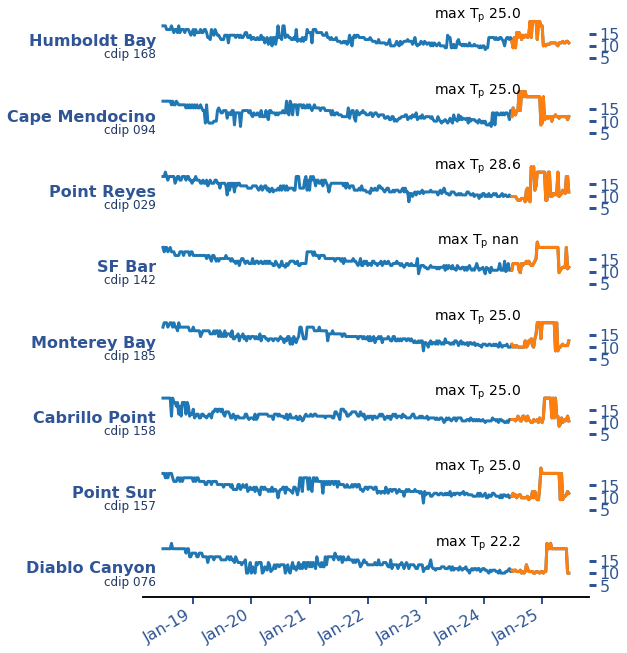

In [75]:
fig, ax = plt.subplots(len(buoy_lookup),sharex=True,gridspec_kw={"hspace":0.25})
# gs1 = gridspec.GridSpec(4, 4)
# gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 
fig.set_size_inches(w=8,h=len(buoy_lookup)*1.5)

fig.autofmt_xdate()

lats = []
lons = []
station_name = []
for i, (key, value) in enumerate(buoy_lookup.items()):
    ds = get_buoy_data(value)
    lat = ds.isel(gpsTime=-1)['gpsLatitude'].values
    lon = ds.isel(gpsTime=-1)['gpsLongitude'].values
    lats.append(lat)
    lons.append(lon)
    station_name.append(key)
    if ds is None:
        ax[i] = format_axis(ax[i])
    else:
        ax_current = ax[i].twinx()
        max_hs = ds['waveTp'].values.max()
        ax_current, ds = plot_buoy_period(ds,ax=ax_current)

        ax_current.set_ylim(0,25)
        ax_current.text(x=.03, y=.4, s=key,
                        size=16,
                        color='#2F5596', 
                        weight='bold',
                        transform=ax_current.transAxes, 
                        horizontalalignment='right')
        ax_current.text(x=.03, y=.2, s='cdip '+value, size=12,color='#203864', transform=ax_current.transAxes, horizontalalignment='right')
        ax_current.text(x=.75, y=.85, s="$\mathrm{max\ T_{p}}$ "+str(round(max_hs,1)), size=14, transform=ax_current.transAxes, horizontalalignment='center')
        ax_current = format_axis(ax_current,right=True)
        ax_current
        ax[i] = format_axis(ax[i])


days = mdates.DayLocator()
daysFmt = mdates.DateFormatter('%b-%d')
# ax_current.xaxis.set_major_locator(years)


ax_current.xaxis.set_major_formatter(daysFmt)
ax[-1].xaxis.set_tick_params(width=2,length=7,colors="#2F5596")
ax[-1].spines['bottom'].set_linewidth(2)
ax_current.spines['bottom'].set_visible(True)

# plt.savefig('tp_whole_region_feet.png',dpi=300,bbox_inches='tight', pad_inches=0.25)
# 

## `joypy` Mountain Plots ##

[See example](https://github.com/sbebo/joypy/blob/master/Joyplot.ipynb) for more information.

Create a data frame with each variable

In [181]:
for i, (key, value) in enumerate(buoy_lookup.items()):
    ds = get_buoy_data(value)

    if i == 0:
        df = pd.DataFrame(ds['waveHs'].to_pandas()*3.28084,columns=[key])
        df_index = df.index
    else:
        raw_df = pd.DataFrame(ds['waveHs'].to_pandas()*3.28084,columns=[key])
        df[key] = raw_df.reindex(df_index,method='nearest',limit=3)

#Only keep the last couple of days
df_recent = df[df.index > datetime.today() - timedelta(days=30)]

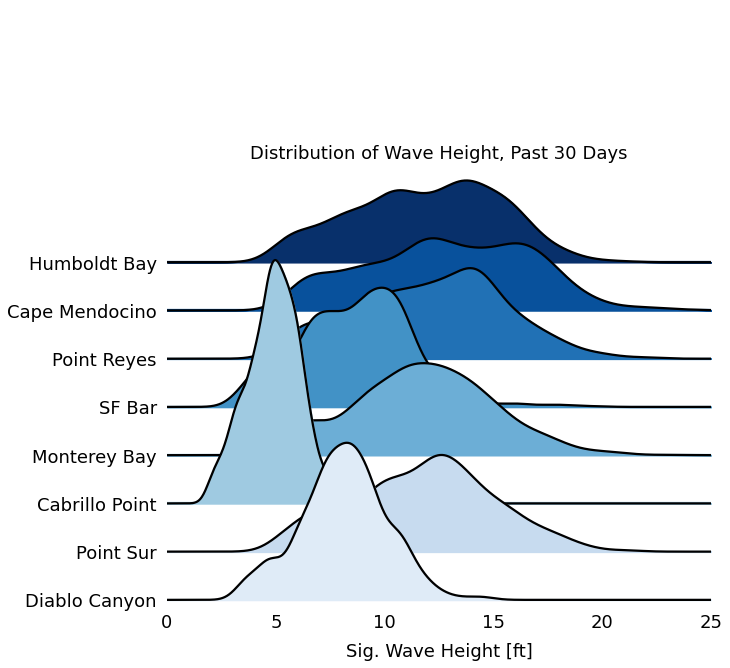

In [188]:
sns.set_context("talk")
x_range = np.arange(0,25)
fig, ax = joypy.joyplot(df_recent, x_range=x_range, colormap=[cm.Blues_r])
fig.set_size_inches(14,12)
ax[-1].set_xlabel('Sig. Wave Height [ft]')
ax[-1].set_xticks(range(0,26,5))
ax[-1].tick_params(direction='out', length=0)
ax[-1].tick_params(axis="x", pad=-25)

plt.title('Distribution of Wave Height, Past 30 Days',y=.75)
plt.savefig('hs_distro_feet.png',dpi=300,bbox_inches='tight', pad_inches=0.25, transparent=True)


In [137]:
coords = pd.DataFrame({'station_names':station_name,'latitude':lats,'longitude':lons})
coords.query("station_names == @key")

,station_names,latitude,longitude
7,Diablo Canyon,35.20369338989258,-120.85916137695312


In [96]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

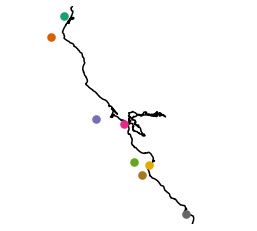

In [180]:
fig, ax = plt.subplots(1, subplot_kw={'projection': ccrs.PlateCarree()})
# sanctuary_outline[(sanctuary_outline['REGION'] == "Pacific Coast") & (sanctuary_outline['EEZ'])].plot(ax=ax)
ax.coastlines('10m')
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='#f49e42'))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='None',lw=6))
ax.set_xlim(-126,-119)
# ax.set_ylim(33.5,)
for i, (key, value) in enumerate(buoy_lookup.items()):
    station = coords.query("station_names == @key")
    cmap = matplotlib.cm.get_cmap('Dark2')
    ax.scatter(station['longitude'],station['latitude'],zorder=10,s=50,color=cmap(i))
#     ax.text(station['longitude']+.5,station['latitude']-.25,value,horizontalalignment='left')
    
fig.patch.set_visible(False)
ax.axis('off')
plt.savefig('map_region_feet.png',dpi=300,bbox_inches='tight', pad_inches=0.25)


In [155]:
import matplotlib.colors as mcolors
import matplotlib


In [166]:
(7+1)/8

1.0